# How to use the Multiparameter persistence Module Approximation library.
This notebook provides a detailed example using the main functions of this library.

## Setup

The easiest way to compile / install this python library is using pip :

In [1]:
# ! pip install --user src/ 

If you want to directly compile it, you can use the following command, which will create a `*.so` in the root folder, which can be imported using python.

In [2]:
# !cd src/ && python setup.py build_ext && find build/ -name "*.so" -exec mv {} ../ \;

In [3]:
import matplotlib.pyplot as plt		# Plot library of Python.
import gudhi as gd   				# TDA library. This will help us generate chain complexes with the simplextree structure.
import numpy as np   				# As math in python is broken we need numpy 
from mma import * 					# Our python library to approximate n-persistence modules.

## Typical pipeline.

### Take a simplextree
In this case we will take a simple simplextree, but in a "real usecase" you will want to take a simplextree generated via a dataset. 

In [4]:
simplextree = gd.SimplexTree()
simplextree.insert([0,1,2])

True

In [5]:
#
#    0---2
#    |**/
#    |*/
#    |/
#    1
#

### Consider a bi-filtration (ie. a list of filtrations of the simplices)

In general you can give as an input an `n`-filtration, but we will stick to `n=2` for the moment, to have access to the plot functions. <br>
If the filtration is given by the filtration that is not complete (eg. only given on the points), it will automatically be completed via a lower star filtration. 

In [6]:
bifiltrations = np.array([
    # bi-filtration #simplex
    [0,0],          # 0
    [0,0],          # 1
    [0,0],          # 2
    [1,2],          # 0 1
    [1,2],          # 0 2
    [1,2],          # 1 2
    [3,3],          # 0 1 2
])

### Consider a rectangle box on which to compute vineyards

Format : [x,y], where x,y defines the rectangle {z : x ≤ z ≤ y}. 

In [7]:
box = [[0,0], [4,4]]

All of the lines intersecting this box will be computed (up to the `precision` defined below), if no box is given, it will generate one depending on the filtration values

### Precision

By default, the custom algorithm will ask for a precision parameter which the control in term of bottleneck distance (and thus interleaving distance) of the approximation.

In [8]:
precision = 0.1

One can also convert the number of computed lines to a precision value with the function `nlines_precision_box`

### Compute `n`-module approximations

Use the `approx` function. It takes the following parameters:
- `simplextree` Can be either a Gudhi simplextree, or a boundary matrix
- `nfiltration` The $n$ filtration, with the **lexicographic order** on simplices. The filtration of the simplextree (with a good order), and the boundary matrix can be retrieved with the `splx2bf` function
- `precision=0.01` Default choice of precision, not often the best one
- `box`            Can be infered by the bifiltration, but not always optimal
- `threshold=True` If set to `True`,  intersects the summands with the box (for plot purposes)
- `verbose = False` : If set to `True`, the `C++` code will give some information about the computation

In [9]:
bimodule_approximation = approx(simplextree, bifiltrations, precision = precision, box=box)

If the module is of dimension 2 you can visualize it using the plot or image function.

The `plot` function takes the following parameters :
- `dimension=-1` The homology dimension to plot (by default all dimension are showed)
- `box` Can be used to "zoom" into the original box.
- `separated=False` If set to true, shows each summand in 1 plot.
- `min_interleaving = 0` Shows only the summands that are at distance at least `min_interleaving` to $0$. This is usefull to speed up the plot, by only showing the large summands.
- several matplotlib flags, such as the `alpha` parameter, cmap, or labels.

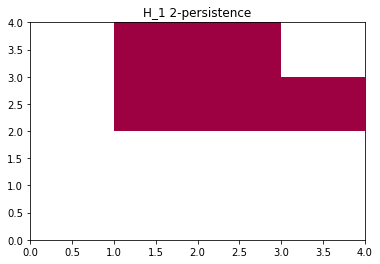

In [10]:
bimodule_approximation.plot(dimension=1)

The `image` function takes the following parameters :
- `dimension=-1` The homology dimension to plot (by default all dimension are showed)
- `resolution =[100,100]` the resolution of the image.
- `bandwidth=1` The bandwidth parameter
- `plot=True` If true, plots the image
- `box` Can be used to "zoom" into the original box. (TODO)
- several matplotlib flags.

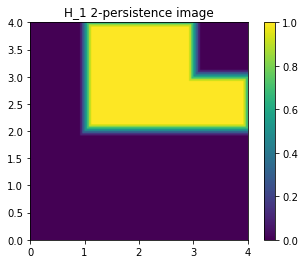

In [11]:
bimodule_approximation.image(dimension=1, bandwidth=0.1, cb=1);

For approximation examples, see the notebook `examples_of_approximations`

## Bifiltration with density example

In [12]:
from mma import noisy_annulus
from sklearn.neighbors import KernelDensity

The noisy annulus dataset that we consider

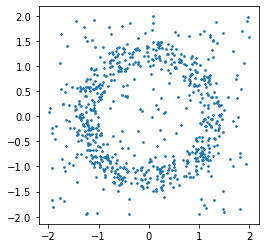

In [13]:
npts = 500
noutliers = (int)(npts * 0.4)
np.random.seed(100)
X = np.block([[np.array(noisy_annulus(1,1.5, npts))], [np.random.uniform(low=-2, high=2, size=(noutliers,2))]] )
fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.scatter(X[:,0], X[:,1],s=3)
plt.show()

In [14]:
# Defines an alpha complex from the point cloud
simplextree = gd.AlphaComplex(points=X).create_simplex_tree()
# Estimates the density of the point cloud
kde = KernelDensity(kernel='gaussian', bandwidth=1/4).fit(X)
# Retrieves the boundary and the filtration
boundary, alpha_filtration = splx2bf(simplextree)
# Defines the bifiltration
codensity_fitlration = -np.array(kde.score_samples(X))
F=[alpha_filtration,codensity_fitlration]
# The box
box = [[0,1.5], [0.5,5]]

In [15]:
bimodule = approx(boundary, F, precision=0.01, box=box, verbose=0)

The annulus clearly appears :)

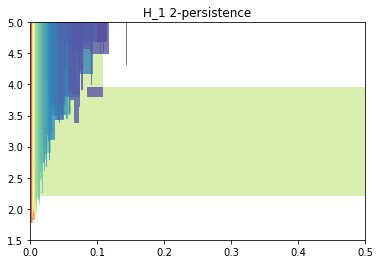

In [16]:
bimodule.plot(alpha=0.8, dimension=1)

The $x$ axis is the alpha complex filtration, and the $y$ axis is the co-log-density (a simplex will appear earlier if it has a bigger density value) 

We can see in that example that there is only 1 significant (green) summand of dimension 1 representing the circle.

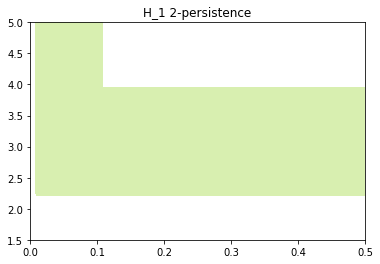

In [17]:
bimodule.plot(alpha=0.8, dimension=1, min_interleaving=0.4)

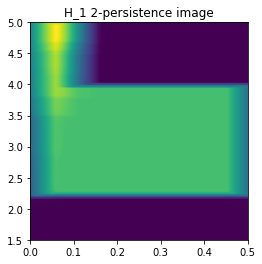

In [18]:
bimodule.image(dimension=1, bandwidth=0.05);

## Higher dimensions

The same syntax applies in higher persistence dimension : 

In [19]:
max_dim = 4
n = simplextree.num_simplices()
# We take a random filtration of the form
F = [[np.random.uniform(low = 0, high = 1) for _ in range(n)] for _ in range(max_dim)]
# And a random box of the same dimension 
box = [[np.random.uniform(low = 0, high = 1) for _ in range(max_dim)], [np.random.uniform(low = 2, high = 3)for _ in range(max_dim)]]
precision=1

In [20]:
%time n_mod_approximation = approx(simplextree, F, precision, box);

CPU times: user 2.04 s, sys: 18 ms, total: 2.06 s
Wall time: 2.04 s


But there is no plotting function in higher dimension.